In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rc('xtick', labelsize = 20) 
matplotlib.rc('ytick', labelsize = 20)

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho
import xgcm

from sklearn import preprocessing

from xhistogram.xarray import histogram
from sklearn import preprocessing

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 251.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38325,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 251.21 GiB
Comm: tcp://127.0.0.1:36701,Total threads: 4
Dashboard: /proxy/38185/status,Memory: 62.80 GiB
Nanny: tcp://127.0.0.1:39383,


In [4]:
db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_control.db'
session_cont = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_flux_forced_vary_heat_uniform.db'
session_heat = cc.database.create_session(db)

session = [session_cont, session_heat]
name = ['Control', 'Pos20W']
expt = ['025deg_jra55_ryf_control', '025deg_jra55_ryf_fluxH_pos20W']

In [5]:
ncoarse = 12

x_min = [-100, -250]
x_max = [ 10 , -100]
y_min = [ 20 ,  20 ]
y_max = [ 75 ,  75 ]
basin = ['NA', 'NP']

k = 0

start_time = '2297-01-01'
end_time = '2301-12-31'

In [6]:
rho0 = 1026
pt_max = [1035.8, 1036.1]

bmin = -10
bmax = 50
bins = np.linspace(bmin, bmax, (bmax - bmin + 1))

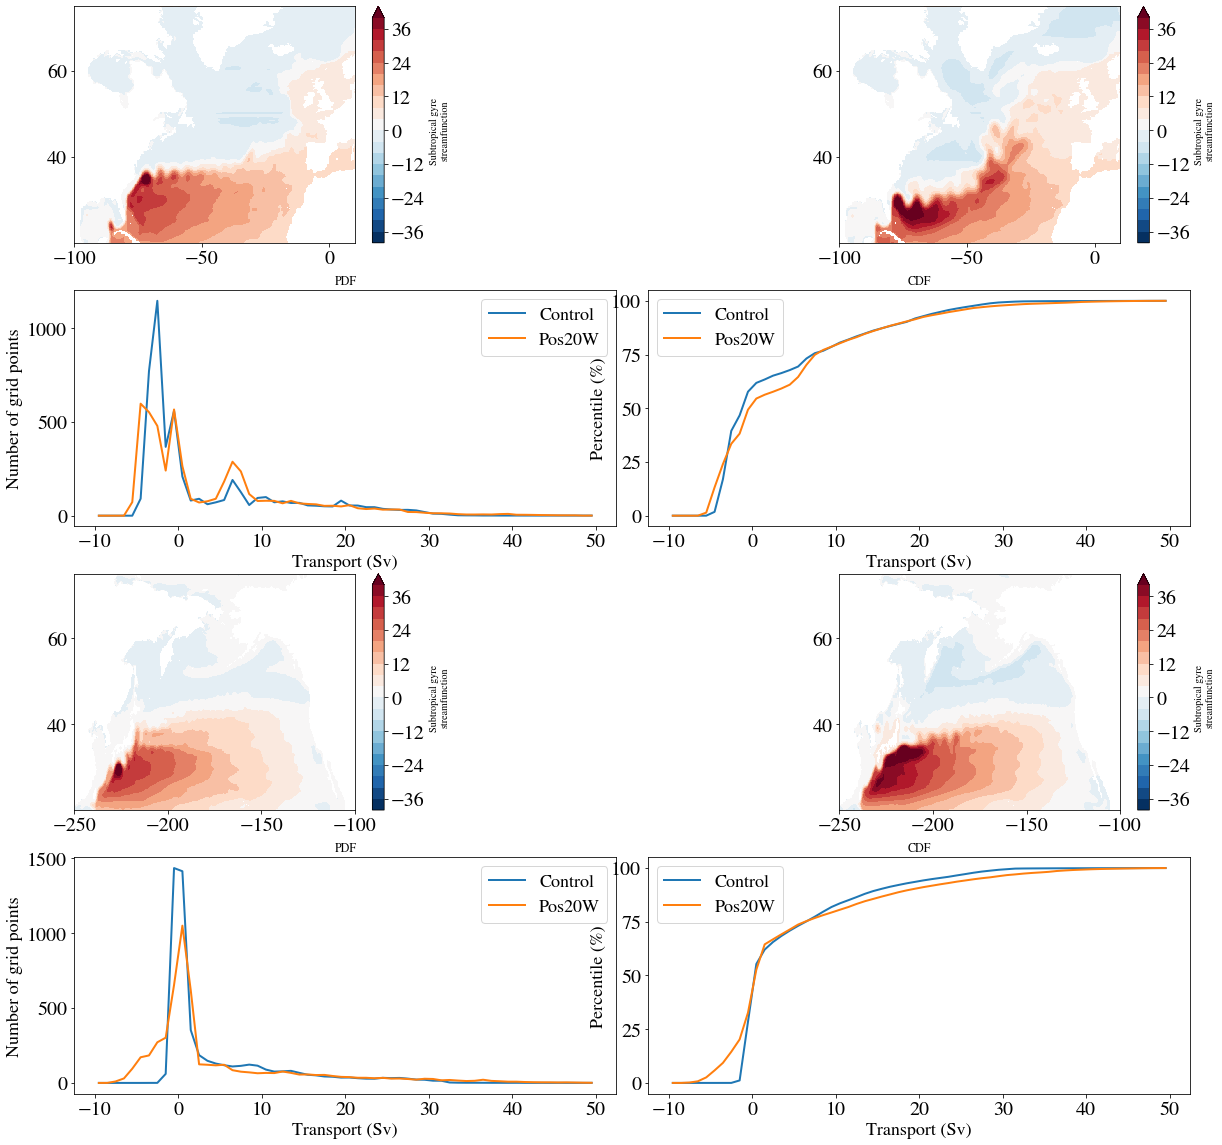

In [7]:
## Setting up a desired grid for maps and probability distributions
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

ax1 = plt.subplot2grid(shape = (4, 6), loc = (0, 0), colspan = 2)
ax3 = plt.subplot2grid(shape = (4, 6), loc = (0, 4), colspan = 3)
ax4 = plt.subplot2grid(shape = (4, 6), loc = (1, 0), colspan = 3)
ax5 = plt.subplot2grid(shape = (4, 6), loc = (1, 3), colspan = 3)

ax6 = plt.subplot2grid(shape = (4, 6), loc = (2, 0), colspan = 2)
ax8 = plt.subplot2grid(shape = (4, 6), loc = (2, 4), colspan = 3)
ax9 = plt.subplot2grid(shape = (4, 6), loc = (3, 0), colspan = 3)
ax10 = plt.subplot2grid(shape = (4, 6), loc = (3, 3), colspan = 3)

axes = [[ax1, ax3, ax4, ax5],
         [ax6, ax8, ax9, ax10]]

for k in [0, 1]:
    
    area_t = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'area_t', n = 1).sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
    area_u = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'area_u', n = 1).sel(xu_ocean = slice(x_min[k], x_max[k])).sel(yu_ocean = slice(y_min[k], y_max[k]))
    T = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'surface_temp', n = 1).sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
    T = T.mean('time')
    
    area_t = area_t.fillna(0)
    area_t_normalize = preprocessing.normalize(area_t)
    area_t_normalize = (area_t_normalize * T)/T
    
    
    for i, j in enumerate(session):
        ty_trans_rho = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'ty_trans_rho', frequency = '1 monthly', 
                                          start_time = start_time, end_time = end_time, use_cftime = True).sel(time = slice(start_time, end_time))
        # A rough estimate for integrating all isopycnals that are upwelling to the ocean's surface
        ty_trans_rho = ty_trans_rho.sel(potrho = slice(1028, pt_max[i]))
        ty_basin = ty_trans_rho.sel(grid_xt_ocean = slice(x_min[k], x_max[k])).sel(grid_yu_ocean = slice(y_min[k], y_max[k]))
        # Conversion of transport to streamfunction, assuming no diapycnal mixing
        psi_basin = ty_basin.cumsum('grid_xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)

        # Interpolating streamfunction from yu-xt to yt-xt grid
        psi = psi_basin.mean('time').sum('potrho')
        psi = psi.rename('Subtropical gyre streamfunction')
        psi = psi.rename({'grid_xt_ocean': 'xt_ocean','grid_yu_ocean': 'yu_ocean'})

        paths = []
        paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
        data = xr.merge((psi, area_t, area_u))
        data.coords['xu_ocean'].attrs.update(axis='X')
        data.coords['xt_ocean'].attrs.update(axis='X',c_grid_axis_shift=0.5)
        data.coords['yu_ocean'].attrs.update(axis='Y')
        data.coords['yt_ocean'].attrs.update(axis='Y',c_grid_axis_shift=0.5)

        g = xgcm.Grid(data, periodic = ['Y'])
        psi_intp = g.interp(psi, 'Y')

        # Placing NaNs at all land grid points
        psi_intp = (psi_intp * T)/T
        psi_intp = psi_intp.rename('Subtropical gyre streamfunction')

        # Creating a area weighted histogram
        whist = histogram(psi_intp, bins = bins, weights = area_t_normalize)
        #whist = whist.where(whist > 0, drop = True)    # If uncommented, the histogram will drop all negative values.

        # Normalising histogram's y-axis by total number of points to give a PDF.
        whist_max = whist.sum().values
        whist = whist.rename({'Subtropical gyre streamfunction_bin': 'bin'})
        whist = whist.rename('Histogram')

        # Creating a CDF from area-weighted-normalised histogram, whist.
        percentile = (whist.cumsum() * 100/whist_max)
        CDF = xr.DataArray(percentile.bin, coords = [percentile.values], dims = ['percentile'], name = 'Gyre_strength')

        # Plotting NA gyre maps
        psi_intp.plot(ax = axes[k][i], levels = np.linspace(-40, 40, 21))
        axes[k][i].set_xlabel('')
        axes[k][i].set_ylabel('')

        # Plotting PDF for all experiments
        whist.plot(label = name[i], ax = axes[k][2])
        axes[k][2].set_title('PDF')
        axes[k][2].set_ylabel('Number of grid points', fontsize = 18)
        axes[k][2].set_xlabel('Transport (Sv)', fontsize = 18)
        axes[k][2].legend(fontsize = 18)
        axes[k][2].grid()

        # Plotting CDF for all experiments
        CDF.plot(label = name[i], ax = axes[k][3], y = 'percentile')
        axes[k][3].set_title('CDF')
        axes[k][3].set_ylabel('Percentile (%)', fontsize = 18)
        axes[k][3].set_xlabel('Transport (Sv)', fontsize = 18)
        axes[k][3].legend(fontsize = 18)
        axes[k][3].grid()

        # If uncommented, the following two lines of code will store CDF as a netCDF file.
        #CDF_ds = CDF.to_dataset()
        #CDF_ds.to_netcdf(path = '/g/data/x77/db6174/Varying_surface_forcing/025deg_flux_forced_uniform/netCDF/Quantiles_pdf_distribution/quantiles_' + name[i] + '_new.nc', 
        #              mode = 'w', format = "NETCDF4", engine = "netcdf4")